In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def RK_k_eval_np(ao_init, _gamma_, _theta_, _eta_, hth):

    pi = np.pi  # constant pi value

#     kk_ = (_gamma_ / (3 * ao_init * _eta_ * np.sqrt(pi))) * ((pi - _theta_) * np.cos(_theta_) + np.sin(_theta_)) * (
#             (pi - _theta_ + np.sin(_theta_) * (np.cos(_theta_))) **
#             (1 / 2)) / (((pi - _theta_) ** 2) * ((np.sin(_theta_)) ** 2))
    
    kk_ = (_gamma_ * hth/ (4 * _eta_)) * ((2*np.cos(_theta_)**2)/ ( ((pi*(hth/2)**2) + hth*2*ao_init)*
            ((-hth/2 * np.sin(_theta_) + hth/8 - (hth*np.cos(2*_theta_))/8 )
             /(hth/2 + ao_init))**2) )
    return kk_


def neck_growth_model_2(b2, int_temp, bond_model_param, t_final, dt, hth):
    # Neck growth calculation using the experiment temperature
    # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == %
    # automatic step size Runge - Kutta - Fehlbergintegration method
    # (Burden and Faires, 1985)
    # To overcome numerical instabilities when theta = 0, the initial BC. is fixed at a time valueslightly different than
    # zero and the corresponding value of theta is determined from Eq. 15
    # They found that the majority of neck growth and sintering in the ABS fibers occurred when the interphase temperature
    # was above 200°C, which meant(based on heat transfer analysis and confirmed by experiments) that the nozzle temperature
    # had a large effect on sintering while environment temperature had little effect. In which delta is time step.
    # For this case, delta is set equal to 2 * dt.  dt is the time step that is used for the interval loop
    # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == %

    # Filament dimensions
    w = 0.8e-3  # Layer Thickness(m)
    hth = hth * 1e-3  # Layer height(m)

    # initial radius: half of layer width in meters
    ao = w / 2

    # Material properties - ABS
    # Surface tension
    gamma_r = bond_model_param[0]

    # with a temp.dependent of Delta Gamma / Delta T = - 0.00345 N / m / K
    delta_gamma = -bond_model_param[1]

    # print(T.ones(T.ceil(t_final / dt) + 1),type(T.ones(T.ceil(t_final / dt) + 1)))
    # delta_gamma = -b1 * T.ones(T.ceil(t_final / dt) + 1)

    # Temperature dependent viscosity eta_r = 5100 Viscosity at temp 240 celc
    eta_r = bond_model_param[2]

    # b2 = 0.056; # model parameter for temp dependent viscosity
    # b2 = beta # model parameter for temp dependent viscosity

    kelv = 273.15  # Kelvin conversion

    # idx = T.argmin(T.abs(int_temp - (240 + kelv)))

    # if int_temp[0] > 240 + kelv:
    #     delta_gamma[0: idx] = -0.0005

    t_r_c = 240  # reference temperature in C
    t_r = t_r_c + kelv  # in K
    
    eta_ = eta_r * np.exp(-b2 * (int_temp[0] - t_r))
    gamma = gamma_r + delta_gamma * (int_temp[0] - t_r)
    theta = np.sqrt(2 * dt * gamma / (eta_ * ao))  # Eq. 15

    pi = (np.pi)  # theano constant pi value

    for jjj in range(3, int(t_final / dt) - 1, 2):
        delta_t = 2 * dt  # 2 * time step

        # k1 calculation at t_bond(i / 2)
        eta_1 = eta_r * np.exp(-b2 * (int_temp[jjj - 1] - t_r))
        gamma_1 = gamma_r + delta_gamma * (int_temp[jjj - 1] - t_r)
        theta_1 = theta
        k1 = RK_k_eval_np(ao, gamma_1, theta_1, eta_1, hth)

        # k2 calculation
        eta_2 = eta_r * np.exp(-b2 * (int_temp[jjj] - t_r))
        gamma_2 = gamma_r + delta_gamma * (int_temp[jjj] - t_r)
        theta_2 = theta + dt * k1
        k2 = RK_k_eval_np(ao, gamma_2, theta_2, eta_2, hth)

        # k3 calculation
        eta_3 = eta_2
        gamma_3 = gamma_2
        theta_3 = theta + dt * k2
        k3 = RK_k_eval_np(ao, gamma_3, theta_3, eta_3, hth)

        # k4 calculation
        eta_4 = eta_r * np.exp(-b2 * (int_temp[jjj + 1] - t_r))
        gamma_4 = gamma_r + delta_gamma * (int_temp[jjj + 1] - t_r)
        theta_4 = theta + 2 * dt * k3
        k4 = RK_k_eval_np(ao, gamma_4, theta_4, eta_4, hth)

        # theta
        theta += (1 / 6) * delta_t * (k1 + 2 * k2 + 2 * k3 + k4)

    # theta_final = theta[-1] # final value of theta to get the final bond length (corresponding the Ref Temp)

    # y = a * sin(theta)
    # save neck growth for each interface on a given layer
#     bond_length = 2 * ao * np.sin(theta) * 1e3  # BL in mm (2*neckRadius)
    bond_length = hth * np.sin(theta) * 1e3  # BL in mm (2*neckRadius)
    
    # void
    wt = 2*ao + hth*theta/4 - hth*np.sin(2*theta)/8
    void = (hth**2 * np.cos(theta) - (pi*(hth/2)**2 - (hth/2)**2 *(2*theta - np.sin(2*theta)) ))/(hth*wt + hth**2 * np.cos(theta))
    
    return bond_length, void

# == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
def bond_model_2(beta_, bondmodelparam, totalparts, interface_temp, t_frame, idx_train, hth):
    # INPUT:
    # bondmodelparam: stores material & model parameters(deterministic)
    # [T_N, v_p, hth, x, y]
    # partinfo: part's information, ...
    # [number of layers, filaments / layer,  total interfaces, and total filaments, T_N v_p hth] in a part

    ctr_ = 0  # counter over number of parts
    dt = 0.1  # time step for the neck growth prediction
    predicted_bl_train = []
    voids = []
    
    # Predict BLfor each interface of each part
    for partid in range(totalparts):  # loop over each manufactured part ID

        int_temp = interface_temp[ctr_]

        # store bond lengths(at Ref_temp) at each interface
        lastnonzeroidx = int_temp.argmin(axis=0)  # return index min. value of temp of each column

        # Predict Neck growth at each interface
        for int_id in idx_train[idx_train < int_temp.shape[1]]:  # loop over each interface
            # for int_id in range(numtotalint[ctr_]): # loop over each interface

            # Neck growth calculation using the temperature field coming from the Abaqus model
            t_final = t_frame[partid][lastnonzeroidx[int_id]]  # final time value

            # Model Bond Length
            bondlengths, void = neck_growth_model_2(beta_, int_temp[0:lastnonzeroidx[int_id], int_id], bondmodelparam,
                                            t_final, dt, hth[partid])

            # Get the bond length at a time when Temperature = Ref_Temp, save BL in mm
            # predicted_bl_train = np.concatenate([bondlengths])
            predicted_bl_train.append(bondlengths)
            voids.append(void)


        idx_train = idx_train[idx_train >= int_temp.shape[1]] - int_temp.shape[1]
        # np.delete(idx_train, idx_train<int_temp.shape[1]) # remove the interfaces that are looped over (previous part)

        ctr_ += 1  # increment counter of number of parts

    # predicted_bl_train = (predicted_bl_train - tt.mean(predicted_bl_train)) / tt.std(predicted_bl_train)
    predicted_bl_train = np.array(predicted_bl_train)
    voids = np.array(voids)
    return predicted_bl_train, voids

def measurements_and_training_data(num_parts, ratio_, bias):
    # =================================================================================================================== %
    # _______________________________________________       INPUTS     ___________________________________________________
    # =================================================================================================================== %
    global time_frame
    wth = 0.8e-3  # width of filaments [m]

    # Reference temperature at which the neck growth is predicted
    ref_temp = 100  # in celcius
    kelv = 273.15  # 0 Celcius in K

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ %

    # =================================================================================================================== %
    # ___________________________________        IMPORT Measured BOND LENGTH DATA     ____________________________________
    # =================================================================================================================== %
    # Directory where measurements are stored
    dir_measurements = "C:/Users/berkc/Box Sync/AM/SecondPaperMultiObjective/ModelCalibration/ManufacturedParts_BL/Round1"
    dir_temp_data = "C:/Users/berkc/Box Sync/AM/SecondPaperMultiObjective/ModelCalibration/AbaqusTempData" \
                    "/TempData_Sample"

    # IMPORT Measured BOND LENGTH DATA
    start_part_id = 1  # starting ID part
    # num_parts = 2                                          # number of parts(the last value)
    total_parts = np.arange(start_part_id, num_parts + 1, dtype='int32')
    index_to_remove = [4, 13, 20]  # remove parts that do not have measurements, i.e., 5,14,21
    total_parts = np.delete(total_parts, index_to_remove)  # remove elements

    ctr = 0  # counter of parts
    # num_total_int = 0                              # counter of interfaces
    int_temperature = []  # list stores interface temperature data of all parts' filaments
    measured_bl_row = []  # list stores bond length (BL) data of all parts
    inp = []
    time = []
    # part_info = np.zeros(total_parts.shape[0], dtype='int')
    part_specs = []
    heights = []

    for part_id in total_parts:  # loop over each manufactured part ID

        # Read Process parameters & bond length measurements
        bl_file = dir_measurements + "/PPSet" + str(part_id) + ".xlsx"

        df = pd.read_excel(bl_file, header=None)  # read the excel file

        num_layers = df.iloc[2, 0]  # # of layers
        num_interfaces = df.iloc[-2, 1]  # # of interfaces/layer
        num_filaments = num_interfaces + 1  # # of filaments/layer

        # num_layers = int(num_layers)
        # num_interfaces = int(num_interfaces)

        num_interfaces_of_a_part = int(num_layers * num_interfaces)  # num. of interfaces of that part
        num_filaments_of_a_part = int(num_layers * num_filaments)  # num. of filaments of that part

        # # # of total interface in all parts
        # num_total_int = num_total_int + num_interfaces_of_a_part

        # save printer temperature, speed, height input for each part
        t_n = df.iloc[0, 1]  # Printer nozzle temperature(ºC)
        v_p = df.iloc[0, 3]  # printer speed mm / s
        hth = df.iloc[0, 5]  # layer height[mm]
        t_n = float(t_n)
        v_p = float(v_p)

        # convert data types to float32 for theano
        # hth = hth.astype('float32')

        # print('T_N, v_p, height:', t_n, v_p, hth, "\n")

        raw_measuredbl = df.iloc[2:-1, 3]  # measured bond lengths between each interface
        raw_measuredbl = raw_measuredbl.astype('float32')

        # reshape the measured bond length array & convert to numpy ndarray
        reshaped_measured_bl = raw_measuredbl.values.reshape(num_interfaces, num_layers, order='F').copy()

        # first column is 1st layer and soon(each row is each interface bond length, BL)
        measured_bl = np.fliplr(reshaped_measured_bl)  # flip matrix left to right

        # store measured BL data of all parts in order reshaped in row
        measured_bl_row.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])

        # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        # Abaqus MODEL
        # open temperature data file for each node and save to time(t) and Temperature in Celcius(T_C)

        # x: length(constant 35 mm)
        # y: width
        # z: height
        zcoord = np.zeros(num_filaments_of_a_part, dtype='float32')
        t_c = []

        # Read Abaqus Temperature data
        folder_name = dir_temp_data + str(part_id)
        file_name = "Job_fdmTher_int" + str(part_id) + '_'
        dir_folder_filename = folder_name + "/" + file_name

        # extract time array once outside the loop
        filename_time = dir_folder_filename + str(1) + ".txt"

        data = pd.read_csv(filename_time, sep=";", header=None, index_col=None)
        data = data.apply(pd.to_numeric, errors='coerce')

        # import time frame data only once since it is same for all filaments
        time_frame = data.iloc[1:, 3]
        time.append(time_frame)
        
        k = 0
        # loop over total number of filaments & read Temperature Data
        for ii in range(1, num_filaments_of_a_part + 1):
            filename = dir_folder_filename + str(ii) + ".txt"  # file name for each filament
            data = pd.read_csv(filename, sep=";", header=None)  # read file
            data = data.apply(pd.to_numeric, errors='coerce')
            zcoord[k] = data.iloc[1, 2]  # read z-coordinate value
            t_c.append(data.iloc[1:, 4])  # read temperature data
            k += 1

        # Convert built Python list of strings to a Numpy float array.
        t_c = np.array(t_c, dtype='float32')

        # convert Celcius to Kelvin
        temp = t_c.T + kelv

        # Average two adjacent lines' temperatures to obtain interface temperatures for each interface on that layer
        # initialize matrix for Interface Temperatures
        int_temp = np.zeros((temp.shape[0], num_interfaces_of_a_part), dtype='float32')

        # Interpolate interface temperatures
        kk_int = 0  # count  # of interfaces
        for jj in range(1, num_layers + 1):  # loop over layers
            for ii in range(2, num_filaments + 1):  # loop over filaments on jj - th layer

                kk_fil = (jj - 1) * (num_filaments - 1) + ii + jj - 2  # filament ID

                # find the index value when (kk + 1)th filament is started to extruded
                t_idx = np.argmax(temp[:, kk_fil] < t_n + kelv)  # Since argmaxx will stop at the first True

                # find the first index that temp value is lower than Ref_temp
                t_idx_ = np.argmax((temp[:, kk_fil] + temp[:, kk_fil - 1]) / 2 < ref_temp + kelv) + 1

                # average two filament's temp. to obtain interface temp.
                int_temp[0:t_idx_ - t_idx, kk_int] = (temp[t_idx:t_idx_, kk_fil - 1] + temp[t_idx:t_idx_, kk_fil]) / 2
                kk_int += 1

        # store each parts' interface temperature in cell array
        int_temperature.append(int_temp)

        # Prediction inputs are x & y coordinates of vertical bond length locations
        # x, y coordinate of layer 1 & interface 1(vertical)
        # x = wth;
        ycoord = 0.5 * hth  # 0.5*height of a layer in mm
        iki_y = ycoord * 2

        # store inputs for GP(model disrepancy at each interface)
        for jj in range(1, num_layers + 1):
            for ii in range(1, num_interfaces + 1):
                # use x & y coordinates of vertical bonds as training data for the GP
                # Inp =[ Temperature, speed, height, x, y ]
                inp.append([t_n, v_p, hth, ii * wth, ycoord + (jj - 1) * iki_y])

        # Store PartInfo array: [number of total interfaces, hth] in a part
        # part_info.append([num_interfaces_of_a_part, hth])
        # part_info[ctr] = num_interfaces_of_a_part
        
        part_specs.append([t_n, v_p, hth, num_layers, num_interfaces])
        heights.append(hth)
        
        ctr += 1  # increment counter to keep track of total number of parts analyzed

        # print('Numberofpart', "NumLayers", "NumInterfaces")
        # print("\t", ctr, "\t", "\t", "\t", num_layers, "\t", "\t", "\t", num_interfaces)

    # Inp: stored inputs for Gaussian process
    # (model disrepancy at each interface):
    #           [T_N, v_p, hth, x, y]
    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')
    int_temperature = np.array(int_temperature) + bias

    # concatenating different size arrays stored in a list
    measured_bl_row = np.concatenate(measured_bl_row, axis=1)
    measured_bl_row = measured_bl_row.T  # transpose s.t. the number of rows matches Inp

    time = np.array(time)

    # Normalize training data

    # inp_normalized = (inp - mean_of_data) / std_of_data  # take mean of each column
    # measured_bl_row = (measured_bl_row - measured_bl_row.mean(axis=0)) / measured_bl_row.std(axis=0)  # take mean of each column
    # inp_normalized = inp
    alldata = np.hstack((inp, measured_bl_row))  # stack 2 numpy arrays column-wise

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = inp.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_ * nl)
#     idx_ = np.random.permutation(nl)
    idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]
    all_data_train = alldata[idx_train, :]

    # mean_of_data = all_data_train.mean(axis=0)
    # std_of_data = all_data_train.std(axis=0)
    # all_data_train = (all_data_train - mean_of_data) / std_of_data  # take mean of each column


    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    all_data_test = alldata[idx_test, :]

    x = all_data_train[:, :-1]  # training data, for all but last column
    yy = all_data_train[:, -1]  # measurements of the training data, last column
    
    return x, yy, ctr, time, int_temperature, idx_train, heights, part_specs

In [43]:
# id of the final part that wants to be included in the analysis, 
# 25 parts but 3 of them are not used so 25-3=22
num_parts_last = 10

# Percent of the whole data is used to train the model
ratio = 1

# bias on the interface temperature predictions
bias = 15.0

# Call the measurements_and_training_data function to get
# x: Training data [printer nozzle temperature (t_n), speed (v_p), layer heigth (hth), x, y (coordinates of bonds)]
# y: bond length measurements at each interface of multiple parts
# numTotalParts: number of total parts analyzed (+1 is the real value because of indexing starts at 0)
# time_frames: time frame data of temperature measurements
# num_interfaces_of_each_part: numpy array stores number of interfaces of each part
# int_temperatures: interface temperature data of each part
# train_idx: randomly selected proportion (ratio) of training data
(X, y, numTotalParts, time_frames, int_temperatures, train_idx, hth, part_specs) = \
    measurements_and_training_data(num_parts_last, ratio, bias)

# print("Total number of interfaces (training data size): ", train_idx.shape[0], train_idx)

# Material parameters for the bond length model
surf_tension = 0.029  # Surface tension
b1_ = 3.45e-3  # Model parameter for temp. dependent surface tension
viscosity = 550.5  # viscosity at 240 C
# beta = 0.056
beta = 0.0355

# viscosity = 150.5  # viscosity at 240 C
# beta = 0.0225

# Input parameters to the neck growth model
ModelParams = [surf_tension, b1_, viscosity]


# Observations: The low fidelity 1-D analytical model
# Predicted_BL: bond length between two filaments of all parts:
Predicted_BL, void_area = bond_model_2(beta, ModelParams, numTotalParts,
                                  int_temperatures, time_frames, train_idx, hth)

C:\Users\berkc\Miniconda3\envs\vandy\lib\site-packages\ipykernel_launcher.py:189: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [44]:
# hth = 0.7*1e-3
# ao = 0.8e-3
# pi = np.pi

# for th in np.arange(0.4,0.8,0.1):
#     theta = th

#     bond_length = hth * np.sin(theta)  # BL in mm (2*neckRadius)
#     print(th,"bl: ", bond_length/hth)

#     # void
#     wt = 2*ao + hth*theta/4 - hth*np.sin(2*theta)/8
#     void = (hth**2 * np.cos(theta) - (pi*(hth/2)**2 - (hth/2)**2 *(2*theta - np.sin(2*theta)) ))/(hth*wt + hth**2 * np.cos(theta))
#     print(th,"void: ", void)

# Predict void density for each part

In [45]:
total_int_minus1, total_int_plus1 = 0, 0

print("Void density\n")

# avg_void = []

# Dictionary of strings and ints
avg_void_dic = {}
avg_bl_dic = {}
bl_void = {}

# loop over number of interfaces of each part
for ii in range(numTotalParts):
    number_interfaces = int_temperatures[ii].shape[1]
    total_int_plus1 += number_interfaces
    
    part_void = void_area[total_int_minus1:total_int_plus1]
    mean_void = np.mean(void_area[total_int_minus1:total_int_plus1])
    
    # dimensionless average bond length (divided by the layer height)
    mean_bl = np.mean(Predicted_BL[total_int_minus1:total_int_plus1])
    dim_mean_bl = mean_bl/part_specs[ii][2]
    
    
#     print(y[total_int_minus1:total_int_plus1])
    
    # dimensionless bl measurements
    y_ = np.mean(y[total_int_minus1:total_int_plus1])/part_specs[ii][2]
    
    print("part", "temp", "speed", "  height", "layers")
    print(ii+1,"", [int(x) for x in part_specs[ii][:2]], "\t", 
          part_specs[ii][2:-1],":\t", mean_void, dim_mean_bl,y_,)
    
    total_int_minus1 = total_int_plus1
    
#     # append avg. void areas
#     avg_void.append(mean_void)
    
    # Adding a new key value pair
    avg_void_dic.update( { (str(ii), str(part_specs[ii][0]), str(part_specs[ii][1]), str(part_specs[ii][2])) : mean_void} )
    avg_bl_dic.update( { (str(ii), str(part_specs[ii][0]), str(part_specs[ii][1]), str(part_specs[ii][2])) : dim_mean_bl} )
    bl_void.update( { (str(ii), str(part_specs[ii][0]), str(part_specs[ii][1]), str(part_specs[ii][2])) : (round(mean_void,6), round(dim_mean_bl,6), round(y_,6))} )

Void density

part temp speed   height layers
1  [220, 33] 	 [0.7, 6] :	 0.026072187833350254 0.760505296703103 0.7078298500605993
part temp speed   height layers
2  [255, 44] 	 [0.42, 10] :	 0.005419631947814732 0.9032833972831147 0.8466101828075591
part temp speed   height layers
3  [241, 28] 	 [0.42, 10] :	 0.009228212574394167 0.8590745068778242 0.8173191121646336
part temp speed   height layers
4  [269, 36] 	 [0.6, 7] :	 0.013869450537566103 0.8404674281880026 0.8594503005345663
part temp speed   height layers
5  [278, 31] 	 [0.7, 6] :	 0.018168207902563325 0.8185659478681435 0.7921080929892405
part temp speed   height layers
6  [262, 26] 	 [0.6, 7] :	 0.016745600975710394 0.8163675806090069 0.8902544776598613
part temp speed   height layers
7  [258, 38] 	 [0.6, 7] :	 0.014119168973144849 0.8383926195317586 0.8987427751223247
part temp speed   height layers
8  [231, 43] 	 [0.42, 10] :	 0.008041920609056574 0.8717350684199314 0.8621381861822947
part temp speed   height layers
9  [2

In [46]:
# # sort dict. values (void areas)
# {k: v for k, v in sorted(avg_void_dic.items(), key=lambda item: item[1])}

In [47]:
# # sort dict. values (void areas)
# {k: v for k, v in sorted(avg_bl_dic.items(), key=lambda item: item[1])}

In [48]:
# sort dict. values (void areas)
print("part", "   temp", "  speed", "  height", "  ", "void_area", " bl_pred", "  bl_obs")
{k: v for k, v in sorted(bl_void.items(), key=lambda item: item[1])}

part    temp   speed   height    void_area  bl_pred   bl_obs


{('1', '255.0', '44.0', '0.42'): (0.00542, 0.903283, 0.84661),
 ('7', '231.0', '43.0', '0.42'): (0.008042, 0.871735, 0.862138),
 ('2', '241.0', '28.0', '0.42'): (0.009228, 0.859075, 0.817319),
 ('3', '269.0', '36.0', '0.6'): (0.013869, 0.840467, 0.85945),
 ('6', '258.0', '38.0', '0.6'): (0.014119, 0.838393, 0.898743),
 ('5', '262.0', '26.0', '0.6'): (0.016746, 0.816368, 0.890254),
 ('8', '235.0', '39.0', '0.6'): (0.0174, 0.811137, 0.722515),
 ('4', '278.0', '31.0', '0.7'): (0.018168, 0.818566, 0.792108),
 ('0', '220.0', '33.0', '0.7'): (0.026072, 0.760505, 0.70783)}

# Compute L2-norm of predicted bond lengths

In [49]:
l_2 = {}

for beta in np.arange(0.0005, 0.05, 0.005):
    
    total_int_minus1, total_int_plus1 = 0, 0
    y_mean_, meanbl_ = [], []

    # Observations: The low fidelity 1-D analytical model
    # Predicted_BL: bond length between two filaments of all parts:
    prediction, _ = bond_model_2(beta, ModelParams, numTotalParts,
                                      int_temperatures, time_frames, train_idx, hth)
    
    for ii in range(numTotalParts):
        number_interfaces = int_temperatures[ii].shape[1]
        total_int_plus1 += number_interfaces

        # dimensionless average bond length (divided by the layer height)
        mean_bl_ = np.mean(prediction[total_int_minus1:total_int_plus1])
        y_mean = np.mean(y[total_int_minus1:total_int_plus1])
    
        meanbl_.append(mean_bl_)
        y_mean_.append(y_mean)
        
        total_int_minus1 = total_int_plus1
        
    # convert to numpy array from list
    meanbl = np.array(meanbl_)
    y_mean = np.array(y_mean_)

    l_2.update({beta : np.linalg.norm(meanbl - y_mean)})

l_2

{0.0005: 0.32784143623243345,
 0.0055: 0.31409235472583363,
 0.010499999999999999: 0.29161822879423654,
 0.015499999999999998: 0.2597719384040003,
 0.020499999999999997: 0.21889015773343262,
 0.025499999999999995: 0.17196222170286504,
 0.030499999999999996: 0.12579689923652468,
 0.0355: 0.0939498671888241,
 0.040499999999999994: 0.09492965765209976,
 0.04549999999999999: 0.12455097680269986}

In [50]:
print(meanbl)
print(y_mean)

[0.4630482  0.3654263  0.33976372 0.47446144 0.52772414 0.45125852
 0.47050316 0.34610602 0.44273928]
[0.4954809  0.35557628 0.34327403 0.5156702  0.55447567 0.5341527
 0.53924567 0.36209804 0.43350905]


In [ ]:
# l2 = {}

# for beta in np.arange(0.0005, 0.05, 0.005):
#     # Observations: The low fidelity 1-D analytical model
#     # Predicted_BL: bond length between two filaments of all parts:
#     Predicted_BL = bond_model_2(beta, ModelParams, numTotalParts,
#                                       int_temperatures, time_frames, train_idx, hth)
#     l2.update({beta : np.linalg.norm(Predicted_BL - y)})

# l2

# Plot Interface temperatures wrt. time

13.86969


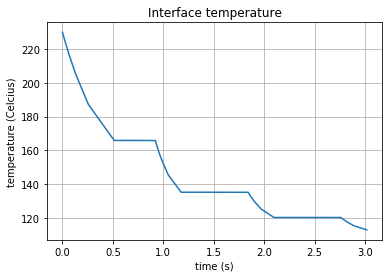

In [61]:
part_num = 6
# print(int_temperatures[6][0,0]-int_temperatures[1][0,0])
int_temperatures[part_num][ int_temperatures[part_num]==bias ] = np.nan

fig, ax = plt.subplots()
ax.plot(time_frames[part_num], int_temperatures[part_num][:,0] - 273.15)
ax.set(xlabel='time (s)', ylabel='temperature (Celcius)',
       title='Interface temperature')
ax.grid()

# Plot material viscosity and surface tension with temperature

In [ ]:
# import numpy as np

# # Material properties - ABS
# # Surface tension
# gamma_r = 0.029

# # with a temp.dependent of Delta Gamma / Delta T = - 0.00345 N / m / K
# delta_gamma = -3.45e-3

# # Temperature dependent viscosity eta_r = 5100 Viscosity at temp 240 celc
# eta_r = 5100

# # model parameter for temp dependent viscosity
# beta = 0.056

# kelv = 273.15  # Kelvin conversion

# t_r_c = 240  # reference temperature in C
# t_r = t_r_c + kelv  # in K

# eta = eta_r * np.exp(-beta * (int_temperatures[0][:,0] - t_r))
# gamma = gamma_r + delta_gamma * (int_temperatures[0][:,0] - t_r)


# fig, ax = plt.subplots()
# ax.plot(eta)
# ax.set(xlabel='time (s)', ylabel='viscosity')
# ax.grid()

# fig, ax = plt.subplots()
# ax.plot(gamma)
# ax.set(xlabel='time (s)', ylabel='surface tension')
# ax.grid()